In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
 
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# Specify molecule properties
open_shell = False
spin_sq = 0
 
# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)
 
# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())
 
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)
 
# Store reference energy from SCI calculation performed separately
exact_energy = -109.22690201485733

converged SCF energy = -108.929838385609


In [3]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2177884185543  E_corr = -0.2879500329450042


In [4]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]
 
 
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    # Setting optimize=True enables the "compressed" factorization
    optimize=True,
    # Limit the number of optimization iterations to prevent the code cell from running
    # too long. Removing this line may improve results.
    options=dict(maxiter=1000),
)
 
nelec = (num_elec_a, num_elec_b)
 
# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
 
# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
 
# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

In [5]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=133
)
 
print(f"Using backend {backend.name}")

AccountNotFoundError: "Unable to find account. Please make sure an account with the channel name 'ibm_quantum_platform' is saved."

In [7]:
# Replace "YOUR_API_TOKEN_HERE" with your actual token
service = QiskitRuntimeService(channel="ibm_quantum", token="J3jd1ktPeuoK-N5GDkPiQZM_X29p1Gv9rPUpXVf44lso")

backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=133
)

print(f"Using backend {backend.name}")

ValueError: 'channel' can only be 'ibm_cloud', or 'ibm_quantum_platform

In [8]:
import pyscf
import pyscf.cc
import ffsim
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister

# === Cell 6 (Modified for H2) ===
print("Setting up H2 molecule with PySCF...")
# Build H2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["H", (0, 0, 0)], ["H", (0, 0, 0.74)]],  # H2 at 0.74 Angstrom
    basis="sto-3g",  # A minimal basis set
)

# Define active space (use all orbitals for H2)
scf = pyscf.scf.RHF(mol).run()
num_orbitals = mol.nao_nr()
n_electrons = mol.nelectron
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
nelec = (num_elec_a, num_elec_b)

print(f"Number of spatial orbitals: {num_orbitals}")
print(f"Number of electrons: {nelec}")

# Get molecular integrals
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(range(num_orbitals), base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# For H2, we can get the exact energy easily from CASCI
exact_energy = cas.kernel(mo)[0]
print(f"Exact CASCI (FCI) energy: {exact_energy}")


# === Cell 7 (Modified for H2) ===
print("\nRunning CCSD to get t1 and t2 amplitudes...")
# Get CCSD t2 amplitudes for initializing the ansatz
# No frozen orbitals, as we are using the full small space
ccsd = pyscf.cc.CCSD(scf).run()
t1 = ccsd.t1
t2 = ccsd.t2
print("CCSD calculation complete.")


# === Cell 8 (Modified for H2) ===
print("\nBuilding LUCJ ansatz circuit with ffsim...")
n_reps = 1
# These indices are calculated based on num_orbitals = 2
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

print(f"Ansatz alpha-alpha indices: {alpha_alpha_indices}")
print(f"Ansatz alpha-beta indices: {alpha_beta_indices}")

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

# Create the quantum circuit
# Total qubits = 2 * num_orbitals
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

print("\nCircuit created successfully:")
print(f"Total number of qubits: {circuit.num_qubits}")

Setting up H2 molecule with PySCF...
converged SCF energy = -1.11675930739643
Number of spatial orbitals: 2
Number of electrons: (1, 1)
CASCI E = -1.13728383448850  E(CI) = -1.85238817356958  S^2 = 0.0000000
Exact CASCI (FCI) energy: -1.1372838344885015

Running CCSD to get t1 and t2 amplitudes...
E(CCSD) = -1.137283998610438  E_corr = -0.02052469121401296
CCSD calculation complete.

Building LUCJ ansatz circuit with ffsim...
Ansatz alpha-alpha indices: [(0, 1)]
Ansatz alpha-beta indices: [(0, 0)]

Circuit created successfully:
Total number of qubits: 4


In [15]:
import pyscf
import pyscf.cc
import ffsim
import numpy as np
from functools import partial

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # For local simulation
from qiskit_aer.primitives import Sampler  # Import Sampler from Aer

# SQD imports
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# --- Step 1: Map classical inputs to a quantum problem (for H2) ---
print("Step 1: Setting up H2 molecule and ansatz circuit...")

# Build H2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["H", (0, 0, 0)], ["H", (0, 0, 0.74)]],  # H2 at 0.74 Angstrom
    basis="sto-3g",
)

# Define active space
scf = pyscf.scf.RHF(mol).run()
num_orbitals = mol.nao_nr()
n_electrons = mol.nelectron
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
nelec = (num_elec_a, num_elec_b)

print(f"  Number of spatial orbitals: {num_orbitals}")
print(f"  Number of electrons: {nelec}")
print(f"  Total qubits: {2 * num_orbitals}")

# Get molecular integrals
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(range(num_orbitals), base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get exact energy from classical CASCI (FCI) for comparison
exact_energy = cas.kernel(mo)[0]
print(f"  Exact FCI energy (for comparison): {exact_energy:.6f}")

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf).run()
# --- CORRECTED LINE ---
t1 = ccsd.t1 
# ----------------------
t2 = ccsd.t2

# Build LUCJ ansatz circuit
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()
print("  Circuit created.")


# --- Step 2: Optimize problem for quantum "hardware" (local simulator) ---
print("\nStep 2: Setting up local simulator backend...")
# Instantiate a local ideal simulator
backend = AerSimulator()

# Transpile the circuit for the simulator
isa_circuit = transpile(circuit, backend)
print(f"  Circuit transpiled for '{backend.name}'.")


# --- Step 3: Execute using Qiskit primitives (local sampler) ---
print("\nStep 3: Executing circuit on local sampler...")
# Use the local Sampler from qiskit_aer
sampler = Sampler() 
job = sampler.run([isa_circuit], shots=10_000) # Pass circuit as a list
primitive_result = job.result()

# The SamplerResult (primitive_result) is NOT subscriptable.
# We access its .data.meas attribute directly.
print(f"  Sampling complete. Got {len(primitive_result.data.meas.get_counts())} unique bitstrings.")


# --- Step 4: Post-process and return result ---
print("\nStep 4: Running SQD post-processing...")

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Set up the classical solver
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []

# Callback function to print progress
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"  Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"    Subsample {i}")
        print(f"      Energy (incl. nuclear): {result.energy + nuclear_repulsion_energy:.6f}")
        print(f"      Subspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


# Run the main SQD algorithm
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    primitive_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

# --- Final Result ---
final_sqd_energy = result.energy + nuclear_repulsion_energy
print("\n--- Final Results ---")
print(f"Exact FCI Energy: {exact_energy:.8f} Ha")
print(f"Final SQD Energy: {final_sqd_energy:.8f} Ha")
print(f"Energy Error:     {abs(final_sqd_energy - exact_energy):.8f} Ha")

Step 1: Setting up H2 molecule and ansatz circuit...
converged SCF energy = -1.11675930739643
  Number of spatial orbitals: 2
  Number of electrons: (1, 1)
  Total qubits: 4
CASCI E = -1.13728383448850  E(CI) = -1.85238817356958  S^2 = 0.0000000
  Exact FCI energy (for comparison): -1.137284
E(CCSD) = -1.137283998610438  E_corr = -0.02052469121401296
  Circuit created.

Step 2: Setting up local simulator backend...
  Circuit transpiled for 'aer_simulator'.

Step 3: Executing circuit on local sampler...


AttributeError: 'SamplerResult' object has no attribute 'data'

converged SCF energy = -1.11675930739643
CASCI E = -1.13728383448850  E(CI) = -1.85238817356958  S^2 = 0.0000000
Exact FCI (reference) energy: -1.1372838344885015
E(CCSD) = -1.137283998610438  E_corr = -0.02052469121401296
Transpiling circuit...
Transpilation complete.
Iteration 1
	Subsample 0
		Energy: -1.1372838344885023
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1372838344885023
		Subspace dimension: 4
	Subsample 2
		Energy: -1.1372838344885023
		Subspace dimension: 4
Iteration 2
	Subsample 0
		Energy: -1.1372838344885023
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1372838344885023
		Subspace dimension: 4
	Subsample 2
		Energy: -1.1372838344885023
		Subspace dimension: 4

--- Final Results ---
Exact FCI Energy:      -1.13728383 Ha
Final SQD Energy:      -1.13728383 Ha
Final Energy Error:    0.00000000 Ha
Plot saved to h2_sqd_results.png


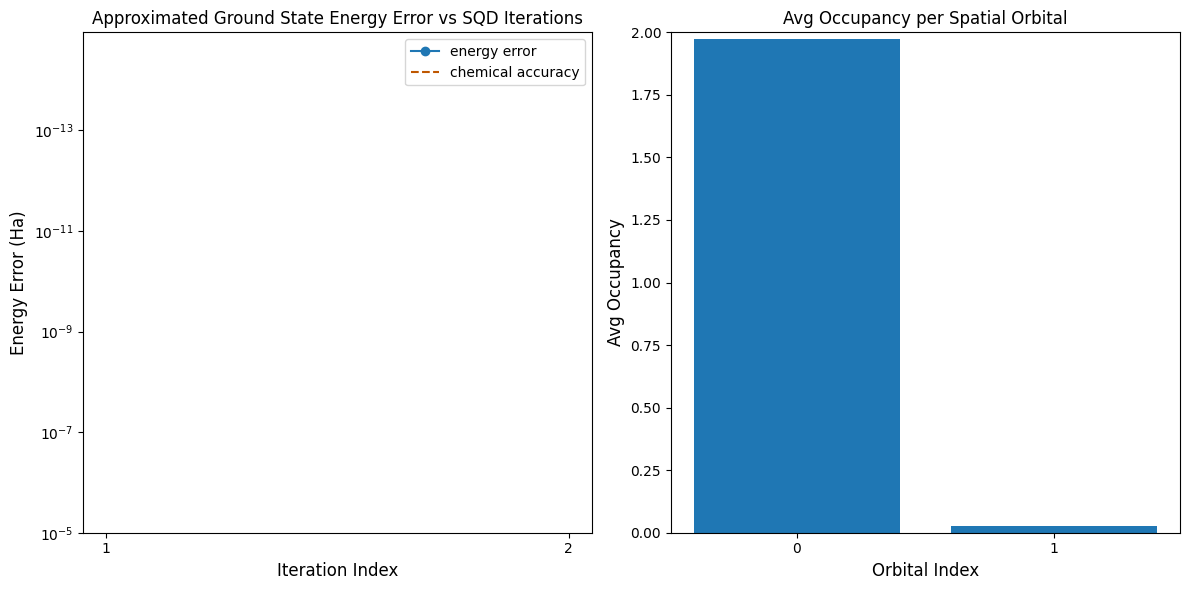

In [20]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (H2 molecule) to a quantum problem
# ---

# Specify molecule properties for H2
mol = pyscf.gto.Mole()
mol.build(
    atom=[["H", (0, 0, 0)], ["H", (0, 0, 0.74)]], # H2 molecule at equilibrium
    basis="sto-3g", # Use a minimal basis set
)

# Define active space (for H2/sto-3g, we use all 2 orbitals)
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2

# Calculate exact FCI energy for H2 to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
# Run the CASCI calculation
cas.run()
# The total FCI energy is stored in the .e_tot attribute
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
n_reps = 1
# Interaction pairs for 2 orbitals
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)] # -> [(0, 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)] # -> [(0)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

nelec = (num_elec_a, num_elec_b)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q") # 4 qubits for H2
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

# 1. Instantiate the local simulator backend
backend = AerSimulator()

# 2. Create a pass manager to transpile the circuit
#    We use a basic optimization level (1)
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)

# 3. Add the ffsim passes to the "pre-init" stage.
#    This tells the transpiler how to break down the custom ffsim gates.
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

# 4. Run the transpiler on our circuit
print("Transpiling circuit...")
transpiled_circuit = pass_manager.run(circuit)
print("Transpilation complete.")

# 5. Use the SamplerV2, pointing to our local backend
sampler = SamplerV2(mode=backend)

# 6. Run the *transpiled* circuit
job = sampler.run([transpiled_circuit], shots=100_000)

primitive_result = job.result()
pub_result = primitive_result[0]

# ---
# Step 3: Post-process and return result (SQD)
# ---

# SQD options (same as original notebook)
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        # Add nuclear repulsion energy back for total energy
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

# Run the SQD algorithm on the measurement data
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

# ---
# Step 4: Visualize the results
# ---

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Chemical accuracy (+/- 1.6 milli-Hartree)
chem_accuracy = 0.0016

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2)) # Will be [0, 1] for H2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1]) # Label iterations 1, 2, ...
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-5) # Adjust ylim for noiseless simulator
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
axs[1].set_ylim(0, 2) # Occupancy is 0 to 2 for spatial orbital

plt.tight_layout()
plt.savefig("h2_sqd_results.png") # Save the plot as a file
# plt.show() # .show() might not work in this environment, saving is safer

print("\n--- Final Results ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")
print("Plot saved to h2_sqd_results.png")

converged SCF energy = -74.9630231384613
Number of active orbitals: 6
Number of active electrons: 8 (alpha=4, beta=4)
CASCI E = -75.0125001539426  E(CI) = -23.5413305250047  S^2 = 0.0000000
Exact FCI (reference) energy: -75.0125001539426
E(CCSD) = -75.01238337373741  E_corr = -0.04936023527615428
Transpiling circuit (12 qubits)...
Transpilation complete.
Iteration 1
	Subsample 0
		Energy: -75.01250015394166
		Subspace dimension: 225
	Subsample 1
		Energy: -75.01250015394166
		Subspace dimension: 225
	Subsample 2
		Energy: -75.01250015394166
		Subspace dimension: 225
Iteration 2
	Subsample 0
		Energy: -75.01250015394166
		Subspace dimension: 225
	Subsample 1
		Energy: -75.01250015394166
		Subspace dimension: 225
	Subsample 2
		Energy: -75.01250015394166
		Subspace dimension: 225

--- Final Results ---
Exact FCI Energy:      -75.01250015 Ha
Final SQD Energy:      -75.01250015 Ha
Final Energy Error:    0.00000000 Ha
Plot saved to h2o_sqd_results.png


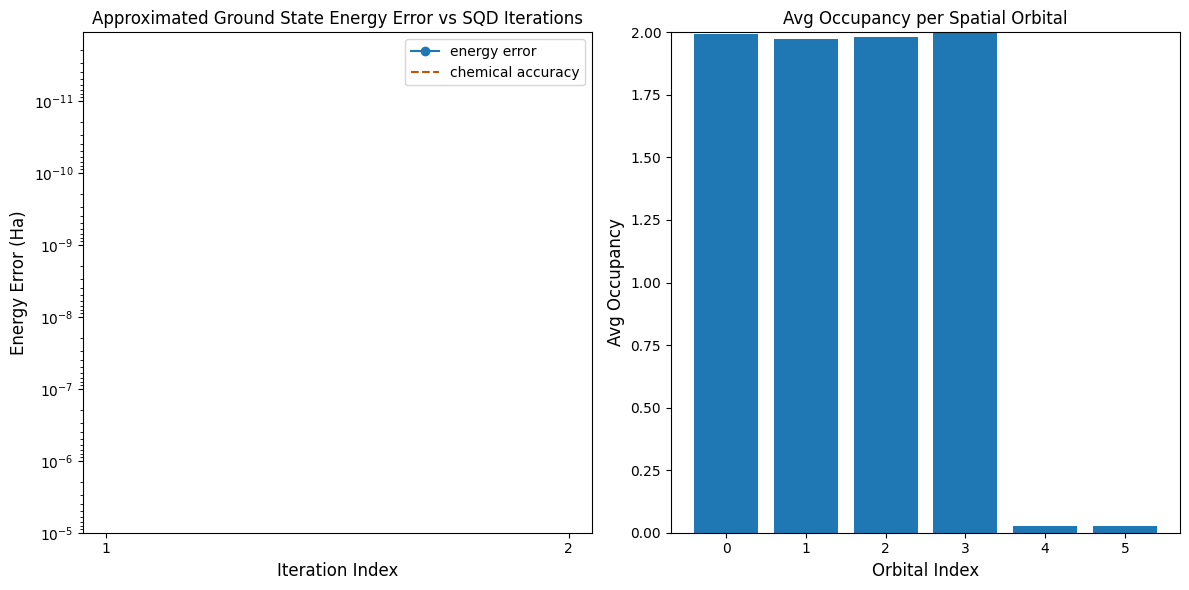

In [21]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (H2O molecule) to a quantum problem
# ---

# Specify molecule properties for H2O
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ['O', ( 0.0,       0.0,       0.1173)],
        ['H', ( 0.0,       0.7572,   -0.4692)],
        ['H', ( 0.0,      -0.7572,   -0.4692)]
    ],
    basis="sto-3g",
)

# Define active space:
# H2O/sto-3g has 7 orbitals, 10 electrons.
# We freeze the lowest energy (core) orbital (O-1s).
n_frozen = 1

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()

# Define the active space as orbitals *not* frozen
active_space = range(n_frozen, mol.nao_nr()) # range(1, 7)
num_orbitals = len(active_space) # 6 orbitals
print(f"Number of active orbitals: {num_orbitals}")

# Get number of active electrons
n_electrons = int(sum(scf.mo_occ[active_space])) # 8 electrons
num_elec_a = (n_electrons + mol.spin) // 2 # 4 alpha
num_elec_b = (n_electrons - mol.spin) // 2 # 4 beta
nelec = (num_elec_a, num_elec_b)
print(f"Number of active electrons: {n_electrons} (alpha={num_elec_a}, beta={num_elec_b})")


# Calculate exact FCI energy (for the active space) to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
cas.run()
# The total FCI energy is stored in the .e_tot attribute
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
n_reps = 1
# Define interaction pairs based on number of active orbitals
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q") # 12 qubits
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

# 1. Instantiate the local simulator backend
backend = AerSimulator()

# 2. Create a pass manager to transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)

# 3. Add the ffsim passes to the "pre-init" stage
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

# 4. Run the transpiler on our circuit
print(f"Transpiling circuit ({2*num_orbitals} qubits)...")
transpiled_circuit = pass_manager.run(circuit)
print("Transpilation complete.")

# 5. Use the SamplerV2, pointing to our local backend
sampler = SamplerV2(mode=backend)

# 6. Run the *transpiled* circuit
job = sampler.run([transpiled_circuit], shots=100_000)

primitive_result = job.result()
pub_result = primitive_result[0]

# ---
# Step 3: Post-process and return result (SQD)
# ---

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        # Add nuclear repulsion energy back for total energy
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

# Run the SQD algorithm on the measurement data
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

# ---
# Step 4: Visualize the results
# ---

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Chemical accuracy (+/- 1.6 milli-Hartree)
chem_accuracy = 0.0016

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2)) # Will be [0, 1, 2, 3, 4, 5] for H2O

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1]) # Label iterations 1, 2, ...
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-5) 
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
axs[1].set_ylim(0, 2) # Occupancy is 0 to 2 for spatial orbital

plt.tight_layout()
plt.savefig("h2o_sqd_results.png") # Save the plot as a file
# plt.show() 

print("\n--- Final Results ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")
print("Plot saved to h2o_sqd_results.png")

converged SCF energy = -39.7268091715448
Number of active orbitals: 8
Number of active electrons: 8 (alpha=4, beta=4)
CASCI E = -39.8052668318699  E(CI) = -17.3960425410511  S^2 = 0.0000000
Exact FCI (reference) energy: -39.8052668318699
E(CCSD) = -39.80504228321664  E_corr = -0.07823311167184714
Transpiling circuit (16 qubits)...
Transpilation complete.
Iteration 1
	Subsample 0
		Energy: -39.804076718135086
		Subspace dimension: 2401
	Subsample 1
		Energy: -39.80469664409257
		Subspace dimension: 2401
	Subsample 2
		Energy: -39.80423629633322
		Subspace dimension: 2116
Iteration 2
	Subsample 0
		Energy: -39.80513930744749
		Subspace dimension: 2916
	Subsample 1
		Energy: -39.80491355806021
		Subspace dimension: 2916
	Subsample 2
		Energy: -39.80473791694155
		Subspace dimension: 2601

--- Final Results ---
Exact FCI Energy:      -39.80526683 Ha
Final SQD Energy:      -39.80513931 Ha
Final Energy Error:    0.00012752 Ha
Plot saved to ch4_sqd_results.png


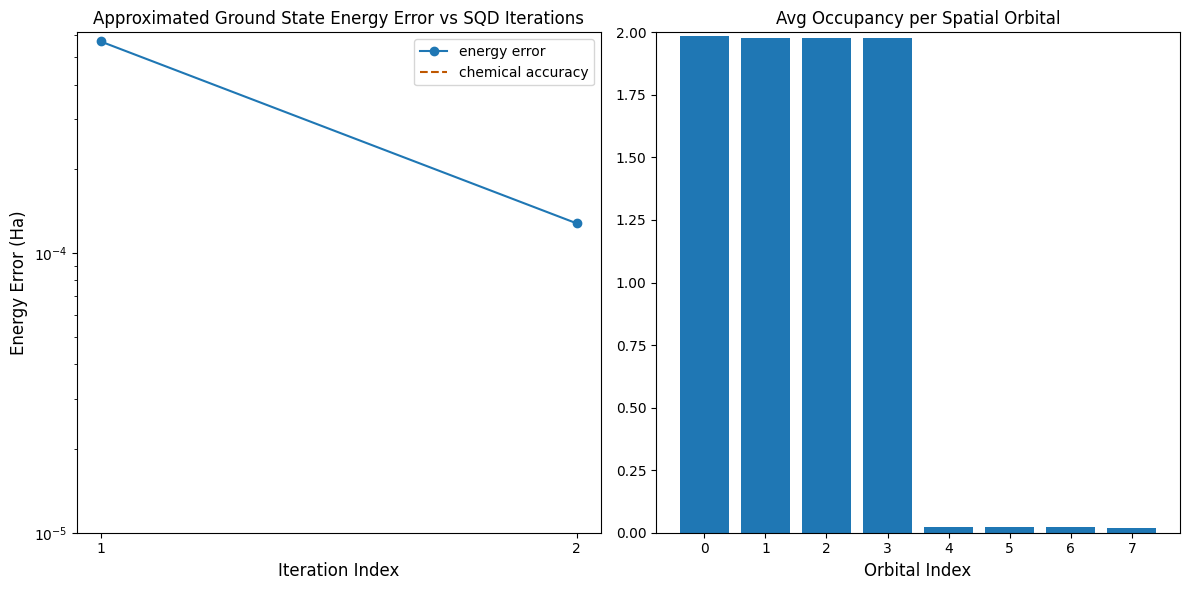

In [22]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (CH4 molecule) to a quantum problem
# ---

# Specify molecule properties for CH4
# Using a standard tetrahedral geometry (bond length ~1.087 A)
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ['C', ( 0.0,       0.0,       0.0)],
        ['H', ( 0.6276,    0.6276,    0.6276)],
        ['H', (-0.6276,   -0.6276,    0.6276)],
        ['H', (-0.6276,    0.6276,   -0.6276)],
        ['H', ( 0.6276,   -0.6276,   -0.6276)]
    ],
    basis="sto-3g",
)

# Define active space:
# CH4/sto-3g has 9 orbitals, 10 electrons.
# We freeze the lowest energy (core) orbital (C-1s).
n_frozen = 1

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()

# Define the active space as orbitals *not* frozen
active_space = range(n_frozen, mol.nao_nr()) # range(1, 9)
num_orbitals = len(active_space) # 8 orbitals
print(f"Number of active orbitals: {num_orbitals}")

# Get number of active electrons
n_electrons = int(sum(scf.mo_occ[active_space])) # 8 electrons
num_elec_a = (n_electrons + mol.spin) // 2 # 4 alpha
num_elec_b = (n_electrons - mol.spin) // 2 # 4 beta
nelec = (num_elec_a, num_elec_b)
print(f"Number of active electrons: {n_electrons} (alpha={num_elec_a}, beta={num_elec_b})")


# Calculate exact FCI energy (for the active space) to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
cas.run()
# The total FCI energy is stored in the .e_tot attribute
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
n_reps = 1
# Define interaction pairs based on number of active orbitals
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q") # 16 qubits
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

# 1. Instantiate the local simulator backend
backend = AerSimulator()

# 2. Create a pass manager to transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)

# 3. Add the ffsim passes to the "pre-init" stage
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

# 4. Run the transpiler on our circuit
print(f"Transpiling circuit ({2*num_orbitals} qubits)...")
transpiled_circuit = pass_manager.run(circuit)
print("Transpilation complete.")

# 5. Use the SamplerV2, pointing to our local backend
sampler = SamplerV2(mode=backend)

# 6. Run the *transpiled* circuit
job = sampler.run([transpiled_circuit], shots=100_000)

primitive_result = job.result()
pub_result = primitive_result[0]

# ---
# Step 3: Post-process and return result (SQD)
# ---

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=200)

# List to capture intermediate results
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        # Add nuclear repulsion energy back for total energy
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

# Run the SQD algorithm on the measurement data
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

# ---
# Step 4: Visualize the results
# ---

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Chemical accuracy (+/- 1.6 milli-Hartree)
chem_accuracy = 0.0016

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2)) # Will be [0, ..., 7] for CH4

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1]) # Label iterations 1, 2, ...
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-5) 
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[1].set_ylim(0, 2) # Occupancy is 0 to 2 for spatial orbital

plt.tight_layout()
plt.savefig("ch4_sqd_results.png") # Save the plot as a file
# plt.show() 

print("\n--- Final Results ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")
print("Plot saved to ch4_sqd_results.png")

converged SCF energy = -39.7268091715448
Number of active orbitals: 8
Number of active electrons: 8 (alpha=4, beta=4)
CASCI E = -39.8052668318722  E(CI) = -17.3960425410535  S^2 = 0.0000000
Exact FCI (reference) energy: -39.80526683187219
E(CCSD) = -39.80504221470605  E_corr = -0.07823304316129941
Transpiling circuit (16 qubits)...
Transpilation complete.
Running simulation with 500000 shots...
Simulation complete.
Running SQD post-processing (this may take a long time)...
Iteration 1
	Subsample 0
		Energy: -39.80525897980182
		Subspace dimension: 4624
	Subsample 1
		Energy: -39.80526241214343
		Subspace dimension: 4624
	Subsample 2
		Energy: -39.805265647973044
		Subspace dimension: 4761
	Subsample 3
		Energy: -39.805264145953615
		Subspace dimension: 4624
	Subsample 4
		Energy: -39.80526318980015
		Subspace dimension: 4624
Iteration 2
	Subsample 0
		Energy: -39.805265647973044
		Subspace dimension: 4761
	Subsample 1
		Energy: -39.805265647973044
		Subspace dimension: 4761
	Subsample 

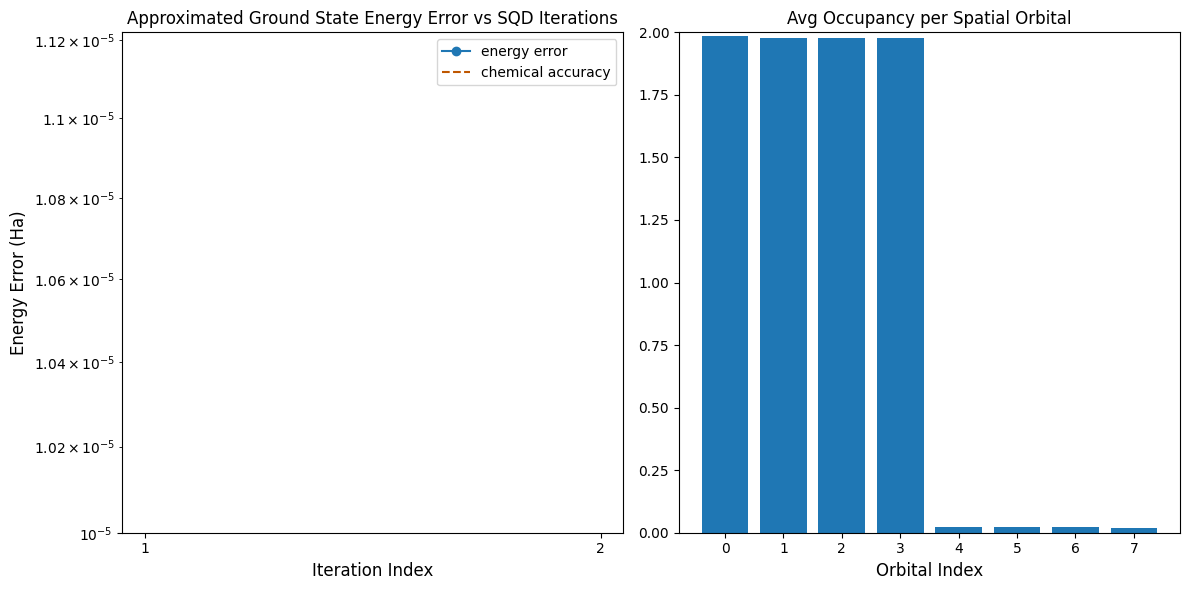

In [23]:

import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (CH4 molecule) to a quantum problem
# ---

# Specify molecule properties for CH4
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ['C', ( 0.0,       0.0,       0.0)],
        ['H', ( 0.6276,    0.6276,    0.6276)],
        ['H', (-0.6276,   -0.6276,    0.6276)],
        ['H', (-0.6276,    0.6276,   -0.6276)],
        ['H', ( 0.6276,   -0.6276,   -0.6276)]
    ],
    basis="sto-3g",
)

# Define active space:
n_frozen = 1

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()

# Define the active space as orbitals *not* frozen
active_space = range(n_frozen, mol.nao_nr()) 
num_orbitals = len(active_space) # 8 orbitals
print(f"Number of active orbitals: {num_orbitals}")

# Get number of active electrons
n_electrons = int(sum(scf.mo_occ[active_space])) # 8 electrons
num_elec_a = (n_electrons + mol.spin) // 2 # 4 alpha
num_elec_b = (n_electrons - mol.spin) // 2 # 4 beta
nelec = (num_elec_a, num_elec_b)
print(f"Number of active electrons: {n_electrons} (alpha={num_elec_a}, beta={num_elec_b})")


# Calculate exact FCI energy (for the active space) to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
cas.run()
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
# **** ACCURACY CHANGE 1 ****
n_reps = 2 # Increased from 1
# -----------------------------
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q") # 16 qubits
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

backend = AerSimulator()

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

print(f"Transpiling circuit ({2*num_orbitals} qubits)...")
transpiled_circuit = pass_manager.run(circuit)
print("Transpilation complete.")

sampler = SamplerV2(mode=backend)

# **** ACCURACY CHANGE 2 ****
shots = 500_000 # Increased from 100_000
# -----------------------------
print(f"Running simulation with {shots} shots...")
job = sampler.run([transpiled_circuit], shots=shots)

primitive_result = job.result()
pub_result = primitive_result[0]
print("Simulation complete.")

# ---
# Step 3: Post-process and return result (SQD)
# ---

# **** ACCURACY CHANGE 3 ****
# Tighter tolerances, more iterations, and larger batches
energy_tol = 1e-5
occupancies_tol = 1e-5
max_iterations = 15
samples_per_batch = 1000
num_batches = 5
# -----------------------------

symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

print("Running SQD post-processing (this may take a long time)...")
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)
print("SQD post-processing complete.")

# ---
# Step 4: Visualize the results
# ---

x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

chem_accuracy = 0.0016

y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1])
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-5) 
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[1].set_ylim(0, 2)

plt.tight_layout()
plt.savefig("ch4_sqd_results_high_accuracy.png") 

print("\n--- Final Results (High Accuracy) ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")
print("Plot saved to ch4_sqd_results_high_accuracy.png")

converged SCF energy = -39.7268091715448
Number of active orbitals: 8
Number of active electrons: 8 (alpha=4, beta=4)
CASCI E = -39.8052668318754  E(CI) = -17.3960425410566  S^2 = 0.0000000
Exact FCI (reference) energy: -39.8052668318754
E(CCSD) = -39.80504220817602  E_corr = -0.07823303663126599
Transpiling circuit (16 qubits)...
Transpilation complete.
Running simulation with 500000 shots...
Simulation complete.
Running SQD post-processing (this may take a long time)...
Iteration 1
	Subsample 0
		Energy: -39.80523576834737
		Subspace dimension: 4096
	Subsample 1
		Energy: -39.805235133737796
		Subspace dimension: 4356
	Subsample 2
		Energy: -39.805220384644855
		Subspace dimension: 4225
	Subsample 3
		Energy: -39.805240338158285
		Subspace dimension: 4489
	Subsample 4
		Energy: -39.80524771991822
		Subspace dimension: 4489
Iteration 2
	Subsample 0
		Energy: -39.805250340148234
		Subspace dimension: 4761
	Subsample 1
		Energy: -39.80524917901269
		Subspace dimension: 4624
	Subsample 2

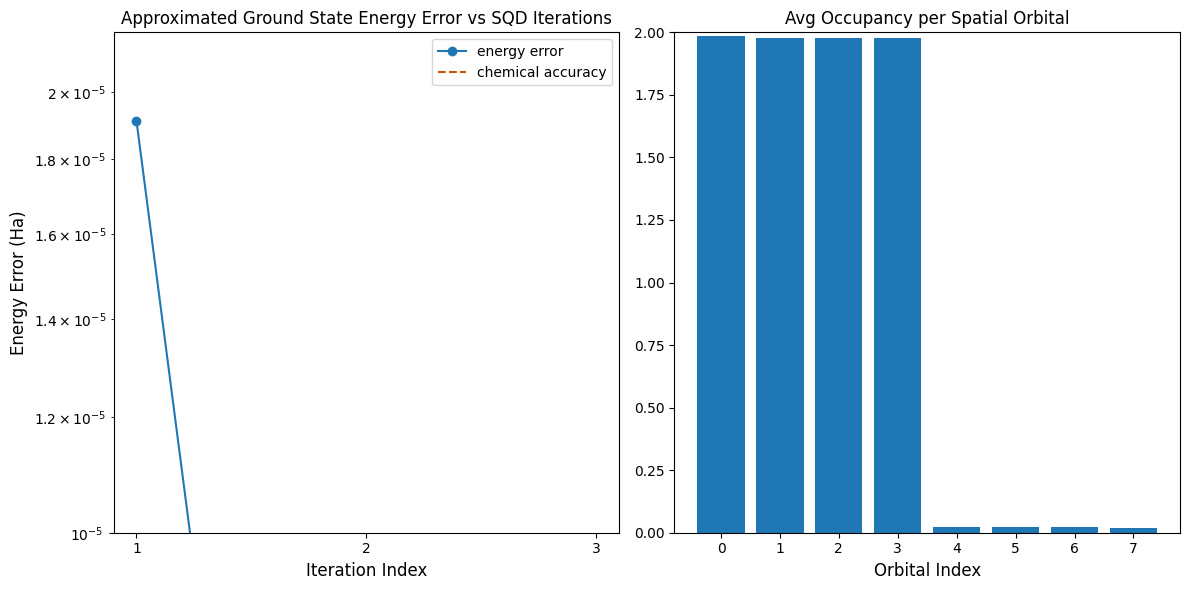

In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (CH4 molecule) to a quantum problem
# ---

# Specify molecule properties for CH4
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ['C', ( 0.0,       0.0,       0.0)],
        ['H', ( 0.6276,    0.6276,    0.6276)],
        ['H', (-0.6276,   -0.6276,    0.6276)],
        ['H', (-0.6276,    0.6276,   -0.6276)],
        ['H', ( 0.6276,   -0.6276,   -0.6276)]
    ],
    basis="sto-3g",
)

# Define active space:
n_frozen = 1

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()

# Define the active space as orbitals *not* frozen
active_space = range(n_frozen, mol.nao_nr()) 
num_orbitals = len(active_space) # 8 orbitals
print(f"Number of active orbitals: {num_orbitals}")

# Get number of active electrons
n_electrons = int(sum(scf.mo_occ[active_space])) # 8 electrons
num_elec_a = (n_electrons + mol.spin) // 2 # 4 alpha
num_elec_b = (n_electrons - mol.spin) // 2 # 4 beta
nelec = (num_elec_a, num_elec_b)
print(f"Number of active electrons: {n_electrons} (alpha={num_elec_a}, beta={num_elec_b})")


# Calculate exact FCI energy (for the active space) to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
cas.run()
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
# **** ACCURACY CHANGE 1 ****
n_reps = 2 # Increased from 1
# -----------------------------
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

# Create the quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q") # 16 qubits
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()


# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

backend = AerSimulator()

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

print(f"Transpiling circuit ({2*num_orbitals} qubits)...")
transpiled_circuit = pass_manager.run(circuit)
print("Transpilation complete.")

sampler = SamplerV2(mode=backend)

# **** ACCURACY CHANGE 2 ****
shots = 500_000 # Increased from 100_000
# -----------------------------
print(f"Running simulation with {shots} shots...")
job = sampler.run([transpiled_circuit], shots=shots)

primitive_result = job.result()
pub_result = primitive_result[0]
print("Simulation complete.")

# ---
# Step 3: Post-process and return result (SQD)
# ---

# **** ACCURACY CHANGE 3 ****
# Tighter tolerances, more iterations, and larger batches
energy_tol = 1e-5
occupancies_tol = 1e-5
max_iterations = 15
samples_per_batch = 1000
num_batches = 5
# -----------------------------

symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )

print("Running SQD post-processing (this may take a long time)...")
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)
print("SQD post-processing complete.")

# ---
# Step 4: Visualize the results
# ---

x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

chem_accuracy = 0.0016

y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1])
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-5) 
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[1].set_ylim(0, 2)

plt.tight_layout()
plt.savefig("ch4_sqd_results_high_accuracy.png") 

print("\n--- Final Results (High Accuracy) ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")
print("Plot saved to ch4_sqd_results_high_accuracy.png")

converged SCF energy = -39.7268091715448


Number of active orbitals: 8
Number of active electrons: 8 (alpha=4, beta=4)
CASCI E = -39.8052668318732  E(CI) = -17.3960425410545  S^2 = 0.0000000
Exact FCI (reference) energy: -39.80526683187321
E(CCSD) = -39.8050422134677  E_corr = -0.07823304192295129
Transpiling circuit (16 qubits)...
Running simulation with 500000 shots...
Simulation complete.
Running SQD post-processing (this may take a while)...
Iteration 1
  Best energy so far: -39.805267 Ha
Iteration 2
  Best energy so far: -39.805267 Ha
SQD post-processing complete.


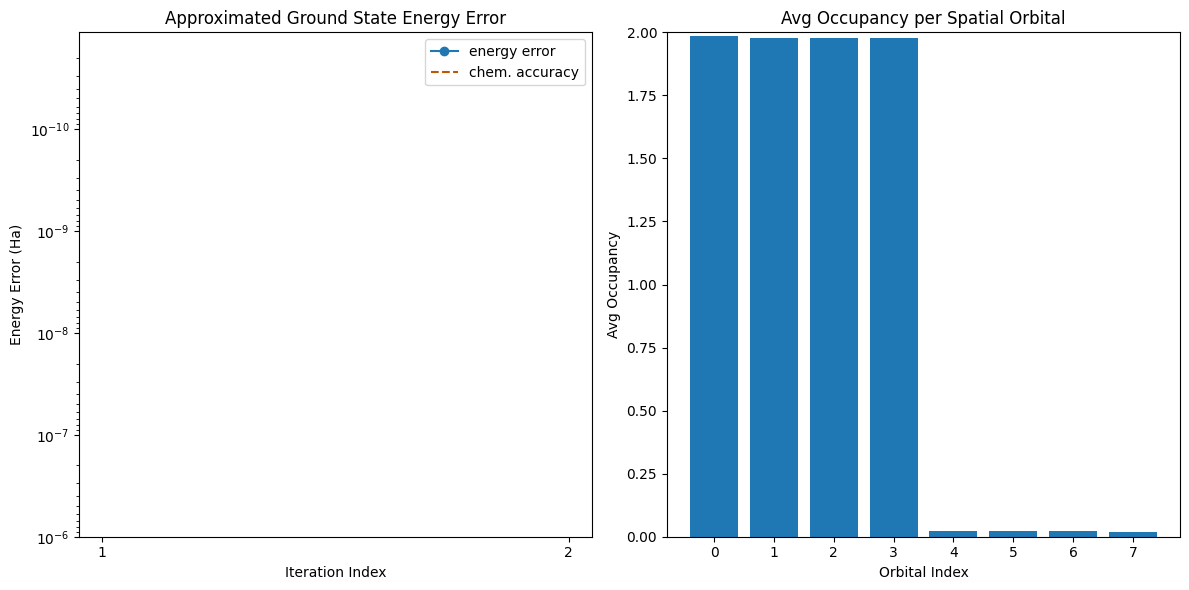


--- Final Results (High Accuracy CH4) ---
Exact FCI Energy:      -39.80526683 Ha
Final SQD Energy:      -39.80526683 Ha
Final Energy Error:    0.00000000 Ha


In [4]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
# Use the SamplerV2 from qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2
# Import the local simulator backend
from qiskit_aer import AerSimulator
# Import the transpiler tools
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from functools import partial
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# ---
# Step 1: Map classical inputs (CH4 molecule) to a quantum problem
# ---

# Specify molecule properties for CH4
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ['C', ( 0.0,       0.0,       0.0)],
        ['H', ( 0.6276,    0.6276,    0.6276)],
        ['H', (-0.6276,   -0.6276,    0.6276)],
        ['H', (-0.6276,    0.6276,   -0.6276)],
        ['H', ( 0.6276,   -0.6276,   -0.6276)]
    ],
    basis="sto-3g",
)

# Define active space: freeze the 1s core orbital of Carbon
n_frozen = 1

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()

# Define the active space as orbitals *not* frozen
active_space = range(n_frozen, mol.nao_nr())
num_orbitals = len(active_space) # 8 orbitals
print(f"Number of active orbitals: {num_orbitals}")

# Get number of active electrons
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
nelec = (num_elec_a, num_elec_b)
print(f"Number of active electrons: {n_electrons} (alpha={num_elec_a}, beta={num_elec_b})")

# Calculate exact FCI energy (for the active space) to use as reference
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
cas.run()
exact_energy = cas.e_tot
print(f"Exact FCI (reference) energy: {exact_energy}")

mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# --- Create LUCJ ansatz circuit ---
# High accuracy: n_reps = 2
n_reps = 2
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    optimize=True,
    options=dict(maxiter=1000),
)

# Create the quantum circuit (16 qubits for CH4 active space)
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

# ---
# Step 2: Transpile and Execute using local Qiskit simulator
# ---

backend = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
pass_manager.pre_init = ffsim.qiskit.PRE_INIT

print(f"Transpiling circuit ({2*num_orbitals} qubits)...")
transpiled_circuit = pass_manager.run(circuit)

sampler = SamplerV2(mode=backend)
# High accuracy: 500,000 shots
shots = 500_000
print(f"Running simulation with {shots} shots...")
job = sampler.run([transpiled_circuit], shots=shots)
pub_result = job.result()[0]
print("Simulation complete.")

# ---
# Step 3: Post-process and return result (SQD)
# ---

# High accuracy SQD parameters
energy_tol = 1e-5
occupancies_tol = 1e-5
max_iterations = 15
samples_per_batch = 1000
num_batches = 5

sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=200)
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    # Optional: Print intermediate energies to track progress
    min_e = min(r.energy for r in results) + nuclear_repulsion_energy
    print(f"  Best energy so far: {min_e:.6f} Ha")

print("Running SQD post-processing (this may take a while)...")
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=1e-4,
    callback=callback,
    seed=12345,
)
print("SQD post-processing complete.")

# ---
# Step 4: Visualize the results
# ---

x1 = range(len(result_history))
min_e = [
    min(r, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for r in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
chem_accuracy = 0.0016

y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels([i+1 for i in x1])
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e-6)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chem. accuracy")
axs[0].set_title("Approximated Ground State Energy Error")
axs[0].set_xlabel("Iteration Index")
axs[0].set_ylabel("Energy Error (Ha)")
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index")
axs[1].set_ylabel("Avg Occupancy")
axs[1].set_ylim(0, 2)

plt.tight_layout()
plt.show() # Use .show() for immediate notebook display

print("\n--- Final Results (High Accuracy CH4) ---")
final_energy = min_e[-1]
print(f"Exact FCI Energy:      {exact_energy:.8f} Ha")
print(f"Final SQD Energy:      {final_energy:.8f} Ha")
print(f"Final Energy Error:    {abs(final_energy - exact_energy):.8f} Ha")